In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyrics/Songs.csv


In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")


In [3]:
data = pd.read_csv("../input/lyrics/Songs.csv")
data.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [4]:
#Printing the names of artists in the lyrics data
print("Artists in the data:\n",data.Artist.value_counts()) 

Artists in the data:
 Eric Clapton          50
David Bowie           50
Leonard Cohen         50
Billy Joel            50
Taylor Swift          50
Billie Eilish         50
Bruce Springsteen     40
The Beatles           35
​twenty one pilots    30
Ray LaMontagne        30
George Michael        30
Bryan Adams           30
Lana Del Rey          30
John Denver           30
Elton John            30
Vance Joy             30
Frank Sinatra         30
Queen                 30
Nat King Cole         30
Bob Dylan             20
Ed Sheeran            20
Name: Artist, dtype: int64


In [5]:
#Printing the size of dataset
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


In [6]:
#Adding a column of numbers of Characters,words and sentences in each msg
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

,No_of_Characters,No_of_Words,No_of_Lines
count,745.000000,745.000000,745.000000
mean,1403.347651,319.338255,46.277852
std,666.721467,156.067038,21.180531
min,1.000000,1.000000,1.000000
25%,946.000000,215.000000,33.000000
50%,1289.000000,291.000000,44.000000
75%,1714.000000,389.000000,56.000000
max,7267.000000,1652.000000,224.000000


<Figure size 1080x1080 with 0 Axes>

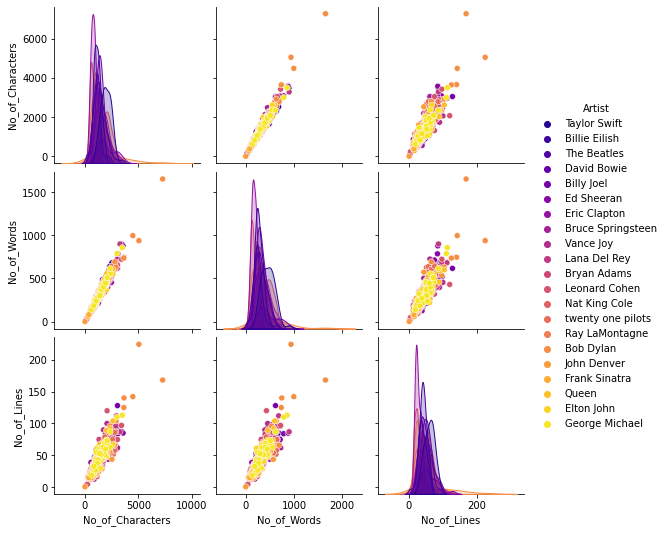

In [7]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

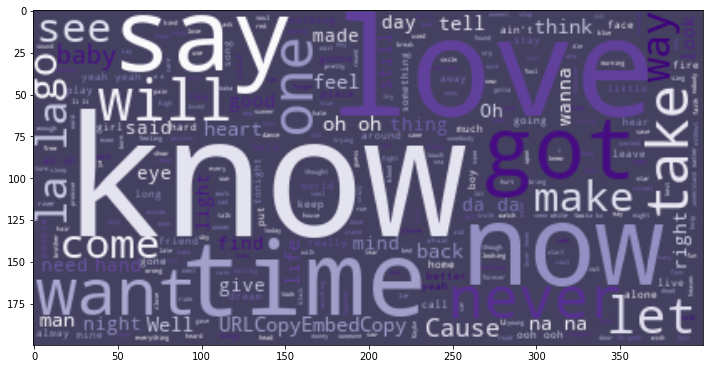

In [8]:
# Generate a word cloud image
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [9]:
# #A function to disply the song in an asthetically pleasing way! lol
# def My_song(song):
#     img = Image.open("../input/image-for-notebook/Pink and White Geometric Marketing Presentation (1).png")
#     Text_on_image = ImageDraw.Draw(img)
#     myFont = ImageFont.truetype("../input/font-style/DancingScript-VariableFont_wght.ttf", 45)
#     Text_on_image.text((620,90), song, font=myFont, fill =(255, 255, 255))
#     return img    
# #Having a look at the first 500 charachters of a random song lyrics
# My_song(data.Lyrics[42][:500])

In [10]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 92


In [11]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


In [12]:
#Keeping only a limited set of characters. 
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', ]
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

#Corpus = re.sub("[^A-Za-z0-9'\.\n]","",Corpus) Alterneativly could be used but I want to pick and chose (:

In [13]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Creating a list of sorted unique characters**

In [14]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 1045494
Number of unique characters: 47


In [15]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 1045454


In [16]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = np_utils.to_categorical(targets)

In [17]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

#Model's Summary               
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 47)                12079     
Total params: 276,271
Trainable params: 276,271
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=20)

Epoch 1/20
8168/8168 [==============================] - 54s 6ms/step - loss: 2.7282
Epoch 2/20
8168/8168 [==============================] - 47s 6ms/step - loss: 2.3022
Epoch 3/20
8168/8168 [==============================] - 46s 6ms/step - loss: 2.1164
Epoch 4/20
8168/8168 [==============================] - 46s 6ms/step - loss: 2.0042
Epoch 5/20
8168/8168 [==============================] - 46s 6ms/step - loss: 1.9189
Epoch 6/20
8168/8168 [==============================] - 47s 6ms/step - loss: 1.8609
Epoch 7/20
8168/8168 [==============================] - 47s 6ms/step - loss: 1.8170
Epoch 8/20
8168/8168 [==============================] - 46s 6ms/step - loss: 1.7793
Epoch 9/20
8168/8168 [==============================] - 46s 6ms/step - loss: 1.7261
Epoch 10/20
8168/8168 [==============================] - 46s 6ms/step - loss: 1.7195
Epoch 11/20
8168/8168 [==============================] - 47s 6ms/step - loss: 1.6986
Epoch 12/20
8168/8168 [==============================] - 47s 6ms/step - lo

In [19]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("Lyrics_Generator.h5")

[Text(0.5, 0, 'Epochs')]

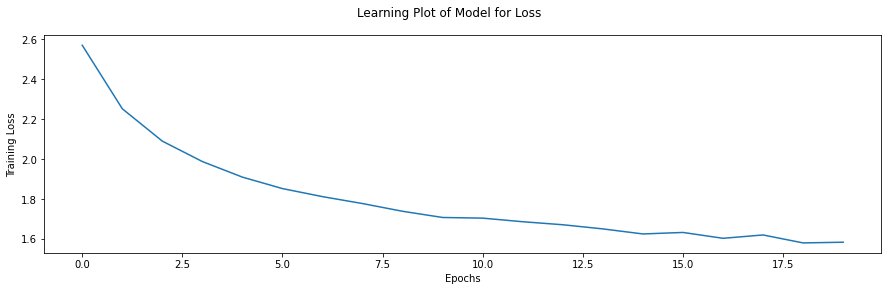

In [20]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [21]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [22]:
#Generating a song from the model
song_1 = Lyrics_Generator("kinda hard to love a girl like me",300 )
#Let's have a look at the song
print(song_1)

kinda hard to love a girl like me and ie sheles is sea the sha
wey ott the share of the siane
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall i


In [23]:
#Generating a song from the model using a song out of the corpus
song_2 = Lyrics_Generator("i'm a sunflower, a little funny", 300)
#Let's have a look at the song


In [24]:
print(song_1)

kinda hard to love a girl like me and ie sheles is sea the sha
wey ott the share of the siane
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall it the same
i could eall i


In [25]:
print(song_2)

i'm a sunflower, a little funny of mend
and i lnved your life ii you wenn all the way
and i don't know why
ie you're lovers and i lnve you

i wanna be your eedh on my mind

she said, "she said " i could eall it lokke
i leet my lind in my head
i leet the share of the siane
and i don't know why
i don't wanna know the wey that i do

